# Linking Anomaly Detection With Multiclassification, A Juice Example.
 By: Christopher Smith

 When performing classification tasks with machine learning a common issue that can be faced with real-world data is "What if something that has never been seen before is introduced to the system?". What we would expect is that the model would try to predict it based on its data to the most similar class instead of identifying it as something new. <u> This is where anomaly detection comes in. What anomaly detection does is take a set of known data that we can call, values that we know exist and are true. </u> Then we can introduce a test set full of data values that it does not know, if the data looks very dismilar to the trained and known data then the model will call it an anomaly. Knowing this, we can create a 2-step machine learning approach whereby we train and anomaly detection system on known data that can then be subsetted into a mutliclassification task. Thereby, future occurences then will filter out unknown data measurements that are new to the system and not similar to the known and still allow us to predict on known cases. See below for an example of this using fruit data collected in the lab.


In [72]:
# Import Libraries for modeling

# For Data processing and import
import numpy as np 
import pandas as pd
from secret_settings import *
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.svm import OneClassSVM, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

# For plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 
sns.set_style('ticks')



 In this dataset are five classes of fruits, oranges, mandarins, tangerines, lemons, and limes. The data is prepared using 12 nanosensors, using a 1 hr endpoint for data collection, and is kept track of by a Date stamp and includes two blank columns as will be seen. The first steps done were loading the data and filtering out orange measurements prior to 2022. The reason is that the orange data extremely varies possibly due to a change in season or even supplier. Therefore, measurements of orange after 2022 are only considered.


In [73]:
# Import the data and visualize first 5 rows
df = secret_data().load_data()
df['Date'] = pd.to_datetime(df['Date']).dt.strftime("%Y-%m-%d")
df


,nGO-A23,MoS2-C12,nGO-A12,MoS2-C7,nGO-T18,nGO-C12,nGO-C7,WS2-T18,MoS2-A23,WS2-C12,MoS2-A12,MoS2-T18,Date,Label,Unnamed: 14,Unnamed: 15
0,12373,4385,18353,3083,23738,14057,23935,518,4025,3522,4230,3155,2021-10-07,orange,NaN,NaN
1,12431,3489,17979,3428,24891,14850,24149,755,3759,3886,3728,3082,2021-10-07,orange,NaN,NaN
2,12678,2935,17968,3327,24948,15062,24271,613,4176,3664,4071,2931,2021-10-07,orange,NaN,NaN
3,12909,3365,18435,3498,24597,14079,23481,545,4558,3492,3975,2995,2021-10-07,orange,NaN,NaN
4,12031,3398,17832,3387,24325,14333,24482,547,4080,3801,4004,3156,2021-10-07,orange,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,13161,2863,28278,1722,22025,2193,6423,7860,474,4452,1901,5627,2021-11-13,lime,NaN,NaN
536,13230,2653,27194,1740,22230,2127,6390,7732,594,4387,2004,5651,2021-11-13,lime,NaN,NaN
537,13515,3036,28207,1709,23175,2147,6344,7759,556,4232,2245,5363,2021-11-13,lime,NaN,NaN
538,13736,2981,27235,1784,22774,2231,6379,8757,388,4219,1987,5340,2021-11-13,lime,NaN,NaN


In [74]:
# Drop orange samples before 2022
con1 = df['Label'] == 'orange'
con2 = df['Date']  <= '2022-01-01'

mask = con1 & con2

df = df.drop(df[mask].index)
df

,nGO-A23,MoS2-C12,nGO-A12,MoS2-C7,nGO-T18,nGO-C12,nGO-C7,WS2-T18,MoS2-A23,WS2-C12,MoS2-A12,MoS2-T18,Date,Label,Unnamed: 14,Unnamed: 15
72,834,1733,2259,1075,5337,186,868,288,2669,2964,3389,1388,2021-12-14,tangerine,NaN,NaN
73,678,1655,2261,1270,6274,325,695,450,2808,3017,3352,1600,2021-12-14,tangerine,NaN,NaN
74,755,1750,2102,1467,5530,349,731,437,2773,2876,3464,1165,2021-12-14,tangerine,NaN,NaN
75,694,1810,2517,1384,5858,373,723,315,2578,2954,3073,1234,2021-12-14,tangerine,NaN,NaN
76,571,1673,2555,1267,6248,230,628,455,2411,3153,3583,1274,2021-12-14,tangerine,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,13161,2863,28278,1722,22025,2193,6423,7860,474,4452,1901,5627,2021-11-13,lime,NaN,NaN
536,13230,2653,27194,1740,22230,2127,6390,7732,594,4387,2004,5651,2021-11-13,lime,NaN,NaN
537,13515,3036,28207,1709,23175,2147,6344,7759,556,4232,2245,5363,2021-11-13,lime,NaN,NaN
538,13736,2981,27235,1784,22774,2231,6379,8757,388,4219,1987,5340,2021-11-13,lime,NaN,NaN


In [75]:
# Remove Date, and unnamed columns, show first 5 rows to confirm
df = df.drop(['Date', 'Unnamed: 14', 'Unnamed: 15'], axis = 1)
df.head()


,nGO-A23,MoS2-C12,nGO-A12,MoS2-C7,nGO-T18,nGO-C12,nGO-C7,WS2-T18,MoS2-A23,WS2-C12,MoS2-A12,MoS2-T18,Label
72,834,1733,2259,1075,5337,186,868,288,2669,2964,3389,1388,tangerine
73,678,1655,2261,1270,6274,325,695,450,2808,3017,3352,1600,tangerine
74,755,1750,2102,1467,5530,349,731,437,2773,2876,3464,1165,tangerine
75,694,1810,2517,1384,5858,373,723,315,2578,2954,3073,1234,tangerine
76,571,1673,2555,1267,6248,230,628,455,2411,3153,3583,1274,tangerine


In [76]:
# Determining number of labels each
print('Fruit class distribution: \n',df['Label'].value_counts())


Fruit class distribution: 
 mandarin     176
tangerine    108
orange        70
lemon         60
lime          54
Name: Label, dtype: int64


# Expected Results of Clustering the data.
 It is known that our favorite orange colored fruits oranges, mandarins, and tarngerines are more similar than lemons and limes. This is due to pH and probably other molecular reasons. Therefore, when we transform the data and run a PCA we would see a clustering of the orange colored fruits and a small separation from lemons and limes. Below a PCA will be shown of this.


As you can see, the three orange colored fruits are more clustered closely than the lemons and limes. This indicates that there are enough differences to possibly perform an anomaly detection.


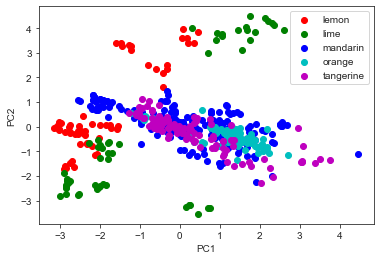

In [77]:
# Displaying the PCA Plot

# Encode the labels
df_n = df.copy()
le = LabelEncoder()
y = le.fit_transform(df_n['Label'])

# Transform data by Z-scale transformation and PCA
scaler = StandardScaler()
df_scale = scaler.fit_transform(df_n.drop(['Label'], axis = 1))
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scale)

print('As you can see, the three orange colored fruits are more clustered closely than the lemons and limes. This indicates that there are enough differences to possibly perform an anomaly detection.')
# Plot the results
colors = ['r', 'g', 'b', 'c', 'm']
for i in range(5):
    plt.scatter(df_pca[y == i, 1], df_pca[y == i, 2], c=colors[i], label=le.classes_[i])
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# The process for anomaly detection.
 The goal of this example is to first demonstrate an algorithm that can be used to correctly identify the orange colored fruits (OMT) from lemons and limes. What this means is, we are considering OMT measurments as non-anomolous that we want to further classify and then we are considering lemons and limes anomolous which are samples that are foreign to our modeling. Therefore, we want our model to discriminate OMT from lemons and limes which should not be further classified later. The first step here will be to separate out the data to train the model. To train the model we will take a subset of orange, mandarin and tangerine samples (df_omt). Then the remainder data under the variable df_ml will contain the remainder OMT samples plus the lemon and limes to validate the model.


In [78]:
# Separating out the data.
df_omt = df.loc[(df['Label'] == 'orange') | (df['Label'] == 'mandarin') |
                (df['Label'] == 'tangerine')]
df_ml = df.loc[(df['Label'] == 'lemon') | (df['Label'] == 'lime')]

print('df_omt only has:', df_omt['Label'].unique())
print('df_ml so far only has:', df_ml['Label'].unique())


df_omt only has: ['tangerine' 'mandarin' 'orange']
df_ml so far only has: ['lemon' 'lime']


In [79]:
# Splitting the OMT data into subsets for training and validation, retaining 80% for training
x_train, x_temp, y_train, y_temp = train_test_split(df_omt.iloc[:, 0:12],
                                                    df_omt['Label'].squeeze(), test_size= 0.2,
                                                    shuffle = True,
                                                    random_state=0)
print('Train Dimensions (measurements, ns): {}, Temporary Dimensions (measurements, ns): {}'.format(x_train.shape, x_temp.shape))


Train Dimensions (measurements, ns): (283, 12), Temporary Dimensions (measurements, ns): (71, 12)


In [80]:
# Appending remainder 20% OMT back to df_ml to make validation set.
x_temp['Label'] = y_temp
df_new = pd.concat([df_ml, x_temp]) # Merge data files.
df_new.info()
df_new.reset_index(drop = True, inplace = True)
print('')
print('Validation set sample distribution: \n',df_new['Label'].value_counts())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 185 entries, 426 to 135
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   nGO-A23   185 non-null    int64 
 1   MoS2-C12  185 non-null    int64 
 2   nGO-A12   185 non-null    int64 
 3   MoS2-C7   185 non-null    int64 
 4   nGO-T18   185 non-null    int64 
 5   nGO-C12   185 non-null    int64 
 6   nGO-C7    185 non-null    int64 
 7   WS2-T18   185 non-null    int64 
 8   MoS2-A23  185 non-null    int64 
 9   WS2-C12   185 non-null    int64 
 10  MoS2-A12  185 non-null    int64 
 11  MoS2-T18  185 non-null    int64 
 12  Label     185 non-null    object
dtypes: int64(12), object(1)
memory usage: 20.2+ KB

Validation set sample distribution: 
 lemon        60
lime         54
mandarin     31
tangerine    25
orange       15
Name: Label, dtype: int64


In [81]:
#Separating out x and y values for model validation
x_test = df_new.iloc[:, 0:12]
y_test = df_new['Label']


In [82]:
# Transforming the training data by fitting a scaler and pca model.
scaler = MinMaxScaler()
pca = PCA(n_components=5, whiten=False)

x_train_scaled = scaler.fit_transform(x_train)
x_train_pca = pca.fit_transform(x_train_scaled)


# Fitting the Anomaly detection model.

 Now that the training data is prepared, a One-class SVM will be trained on the 80% subset OMT samples. The model considers non-anomolous data as "1" and anomalies detected as "-1" as will be seen in the test prediction set (x_test).


In [83]:
# Perform anomaly detection training using One-class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.5)
ocsvm.fit(x_train_pca)


OneClassSVM(gamma=0.01)

In [84]:
# Transform test set and predict
x_test_scaled = scaler.transform(x_test)
x_test_pca = pca.transform(x_test_scaled)
anomalies = ocsvm.predict(x_test_pca)
print('Predicted output of anomaly detection on test samples', anomalies)


Predicted output of anomaly detection on test samples [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1  1  1
 -1  1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1 -1  1  1 -1 -1  1 -1 -1 -1 -1  1  1  1  1 -1  1  1 -1  1 -1 -1  1
  1  1  1  1 -1  1  1 -1  1  1 -1  1 -1 -1  1  1  1]


In [85]:
# Cleaning y_test and setting to a new value of y_convert.
y_convert = [] # Empty list to take y_test values and denoting them as 1 for OMT samples of -1 for lemon and lime.
for i in range(0, len(y_test)):
    if (y_test[i] == 'orange' or y_test[i] == 'mandarin' or y_test[i] == 'tangerine'):
        y_convert.append(1)
    
    else:
        y_convert.append(-1)
print('Show distribtution of anomaly values:', y_convert)


Show distribtution of anomaly values: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Prediction results of Anomaly detection.
 Below is the classification report and confusion matrix of the anomaly detection. The model overall performed at 85% accuracy. What is clear is that the model has a lower false positive rate than false negative; predicting more non-anomolous (1) than anomolous samples (-1). However, in this scenario it would be more preferred to have a higher false negative rate than false positive rate as this could be used as a rapid screening tool for decision factors in more complex analytical instrumentation. Nonetheless, this is an example and we will continue to step 2 which is now the multi-classification conversion.


              precision    recall  f1-score   support

          -1       0.79      0.95      0.86       114
           1       0.88      0.59      0.71        71

    accuracy                           0.81       185
   macro avg       0.83      0.77      0.78       185
weighted avg       0.82      0.81      0.80       185



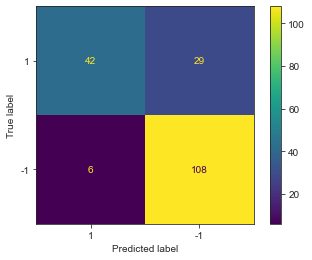

In [86]:
# Show classification report
print(classification_report(np.array(y_convert), np.array(anomalies)))
disp = ConfusionMatrixDisplay(confusion_matrix(y_convert, anomalies, labels = [1, -1]), display_labels = [1, -1])
disp.plot()
plt.show()

# Developing Multi-classification Approach.
 Now that we have developed the first step which was anomaly detection. Now we will perform a mutliclassification for only OMT samples. The purpose of the anomaly detection was to separate out non OMT samples for future prediction of OMT samples only. Though we will see some contamination of non-OMT samples in prediction, this is to demonstrate the proof-of-principal. For multiclassification, we will use a strategy of a StandScaling transformation, followed by a PCA over 5 components which will then be modeled on a SVM with no parameterization for simplicity sake.


In [87]:
# Preparing the training data and model.
SM = SVC()
SM.fit(X=x_train_pca, y=y_train)

# Preparing test data based on anomaly detection output
df_new['Anomaly#'] = anomalies # Set new column factoring anomaly output, then separate for only values that are 1.
df_non_anom = df_new.loc[df_new['Anomaly#'] == 1] # Keep only non-anomolous
df_non_anom.drop(['Anomaly#'], inplace = True, axis = 1)
x_anom = df_non_anom.iloc[:, 0:12] #Selecting x data for nanosenosrs
y_anom = df_non_anom['Label']

x_anom_scaled = scaler.transform(x_anom)
x_anom_pca = pca.transform(x_anom_scaled)

y_pred = SM.predict(x_anom_pca)



# Interpreting multiclassification prediction.
 Now that the modeling and prediction is done. See below for results. Overall, the modeling performed at above 70% accuracy. The reason for this is that the model was not trained for lemon data which should have been filtered during the anomaly detection step. This should demonstrate the importance of using an anomaly detection approach to identify unknowns in a system that our model is not trained for. Though the predictive accuracy is poor, this is an example dataset using different fruits and the modeling parameters were not tuned. If effort were to be placed for tuning parameters, filtering out nanosenosrs, etc. then the accuracy might be able to be improved.

              precision    recall  f1-score   support

       lemon       0.00      0.00      0.00         6
    mandarin       0.62      0.83      0.71        12
      orange       0.75      1.00      0.86        12
   tangerine       0.88      0.78      0.82        18

    accuracy                           0.75        48
   macro avg       0.56      0.65      0.60        48
weighted avg       0.67      0.75      0.70        48



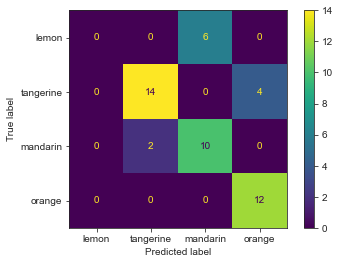

In [88]:
#Providing classification metrics
print(classification_report(np.array(y_anom), np.array(y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix(y_anom, y_pred, labels = df_non_anom['Label'].unique()), display_labels = df_non_anom['Label'].unique())

disp.plot()
plt.show()
